In [25]:
# Import packages and libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from bertopic import BERTopic

print(tf.__version__)  # 2.0.0-beta0

2.11.0


In [26]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/Dylan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Dylan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset
Segmenting US court decision opinions into issue parts: 316 court decisions on cyber crime and trade secrets, manually segmented into 6 content based "types" (encompassing categories like "Introduction", "Dissent", or "Background").

In [ ]:
# Load the dataset and examine the contents
df = pd.read_json("../Dylan/Projects/trade_secret_cases.json")
df.head()

In [ ]:
# Inspect an example of a court decision
print(df.loc[0]['annotations'])
print(df.loc[0]['text'])
print(df.loc[0]['name'])

In [29]:
# Create a function to extract a specific section of a court decision
pd.set_option('display.max_colwidth', None)

def extract(df, name, section):
    """
    This function extracts the text of a court decision according to its name and type of annotation.
    """
    # Search for the name of the court decision
    row = df.query(f"name == '{name}'")
    
    # Search for the text of the relevant section
    text = df.iloc[row.index]['text']
    
    # Iterating through a list of dictionaries
    for index in range(len(row['annotations'])): # prints 0 1 2 3 4
        for key in row['annotations'][index]: # prints start end type
            if section in key.values():
                # Assign start and end indexes
                start = row['annotations'][index][index]['start']
                end = row['annotations'][index][index]['end']

                # Slice text using start and end indices
                # print(start, end)
                print(f"This is the {section} section from the {name} case: ")
                return text.str[start-1:end]

extract(df, 'Advance Biofactures Corp. v. Greenberg (1984).txt', 'Background')

This is the Background section from the Advance Biofactures Corp. v. Greenberg (1984).txt case: 


0    \n103 A.D.2d 834 (1984) \n\n  Advance  Biofactures  Corporation, Appellant,   \nv.   \nJacob  Greenberg  , Respondent \n\nAppellate Division of the Supreme Court of the State of New York, Second Department. \n\nJuly 30, 1984 \n\nWeinstein, J. P., Niehoff, Rubin and Eiber, JJ., concur. \n\n¶ Order affirmed, without costs or disbursements. \n
Name: text, dtype: object

In [30]:
tokenizer = Tokenizer(oov_token="<OOV>") # replace words we don't recognise with out of vocabulary token
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
# print(word_index)

sequences = tokenizer.texts_to_sequences(df['text'])
# for neural networks
# padded = pad_sequences(df['text'])

Use the analysis as input and the conclusion as output. (Predict outcomes of legal case)
LDA for topic modelling (Topic Classification of legal cases)

In [31]:
# Create train and test sets 


Removing stop words as a preprocessing step is not advised as the transformer-based embedding models that we use need the full context in order to create accurate embeddings. Instead, we can use the CountVectorizer to preprocess our documents after having generated embeddings and clustered our documents. 

In [ ]:
# Topic Modelling
# Retrieve all the text data
docs = df["text"].values.tolist()
# Fit a BERTopic model onto dataset
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)
# Access the frequent topics that were generated
topic_model.get_topic_info()
# Extract information at a document level
topic_model.get_document_info(docs)

In [ ]:
# Topics Distribution
topic_dist_model = BERTopic().fit(docs)
# Approximate the topics distributions for our documents
topic_distr, _ = topic_dist_model.approximate_distribution(docs)
# Visualize the distribution of the topics in a document
topic_dist_model.visualize_distribution(topic_distr[1])

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_dist_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df_viz = topic_dist_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df_viz

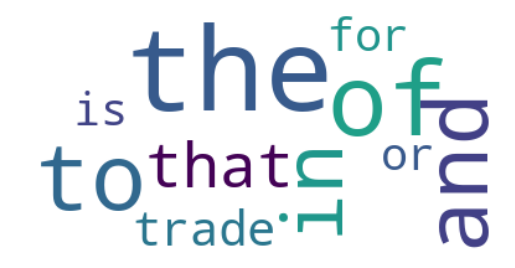

In [39]:
# Topic Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=1)